In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2 as cv
import imageio
import pyMRAW
import scipy as sp
import pyidi
import copy
import os

from typing import Union

%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\kristofc\Doktorat\Projekti\pyidi\.venv\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 150000, Original total frame: 621319)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


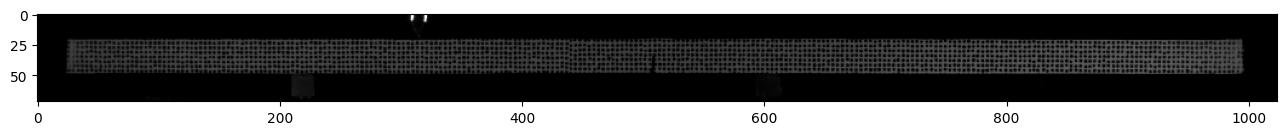

In [2]:
file = "C:\\Users\\kristofc\\Doktorat\\Podatki\\20201011_Nosilec_zareza_speckle\\video_001.cihx"

video = pyMRAW.load_video(file)
cih = video[1]
cih

plt.rcParams['figure.figsize'] = (16,6)

fig = video[0][0]#[:150000,:,25:995]

plt.imshow(fig, 'gray')

In [3]:
vect_0 = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\vect_0.txt")
vect_1 = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\vect_1.txt")
coord  = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\coord.txt")

# coord[:,[0,1]] = coord[:,[1,0]]

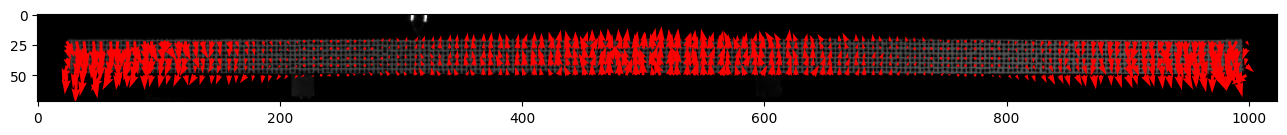

In [4]:
mode_0 = vect_0[0,:]
mode_1 = vect_1[0,:]

disp = np.column_stack((mode_0, mode_1))

plt.imshow(fig, 'gray')
# plt.scatter(coord[:,1], coord[:,0])
plt.quiver(coord[:,1], coord[:,0], mode_1, mode_0, color = 'r', scale = 1.1)

In [12]:
vid = pyidi.pyIDI(file)
vid.set_points(points=coord)

res = pyidi.postprocessing.motion_magnification(video=vid, 
                                                disp=disp, 
                                                mag_fact=500)

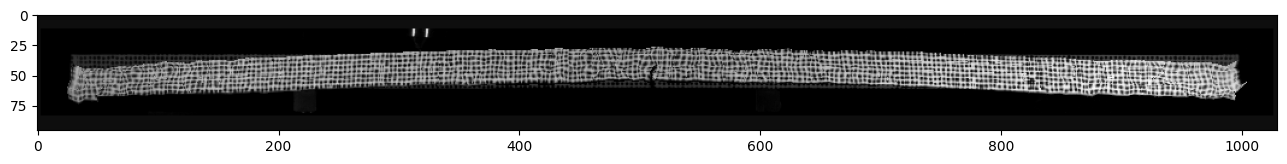

In [13]:
plt.imshow(res, 'gray')

In [11]:
# pyidi.postprocessing.animate(video = vid,
#                              disp = disp,
#                              mag_fact = 500,
#                              fps = 60,
#                              n_periods = 1,
#                              filename='c:/Users/kristofc/Doktorat/Projekti/my_folder/my_video')

Video saved in file: c:/Users/kristofc/Doktorat/Projekti/my_folder/my_video.mp4
